# Athena++ Disk Model (`pgen/disk.cpp`)
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  09/03/2024          |
| Updated |  09/03/2024          |

## Theoretical Model

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{p_\mathrm{slope}} \\
  \rho_\mathrm{mid}(r) &= \rho_0(r_0)^{d_\mathrm{slope}}\\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

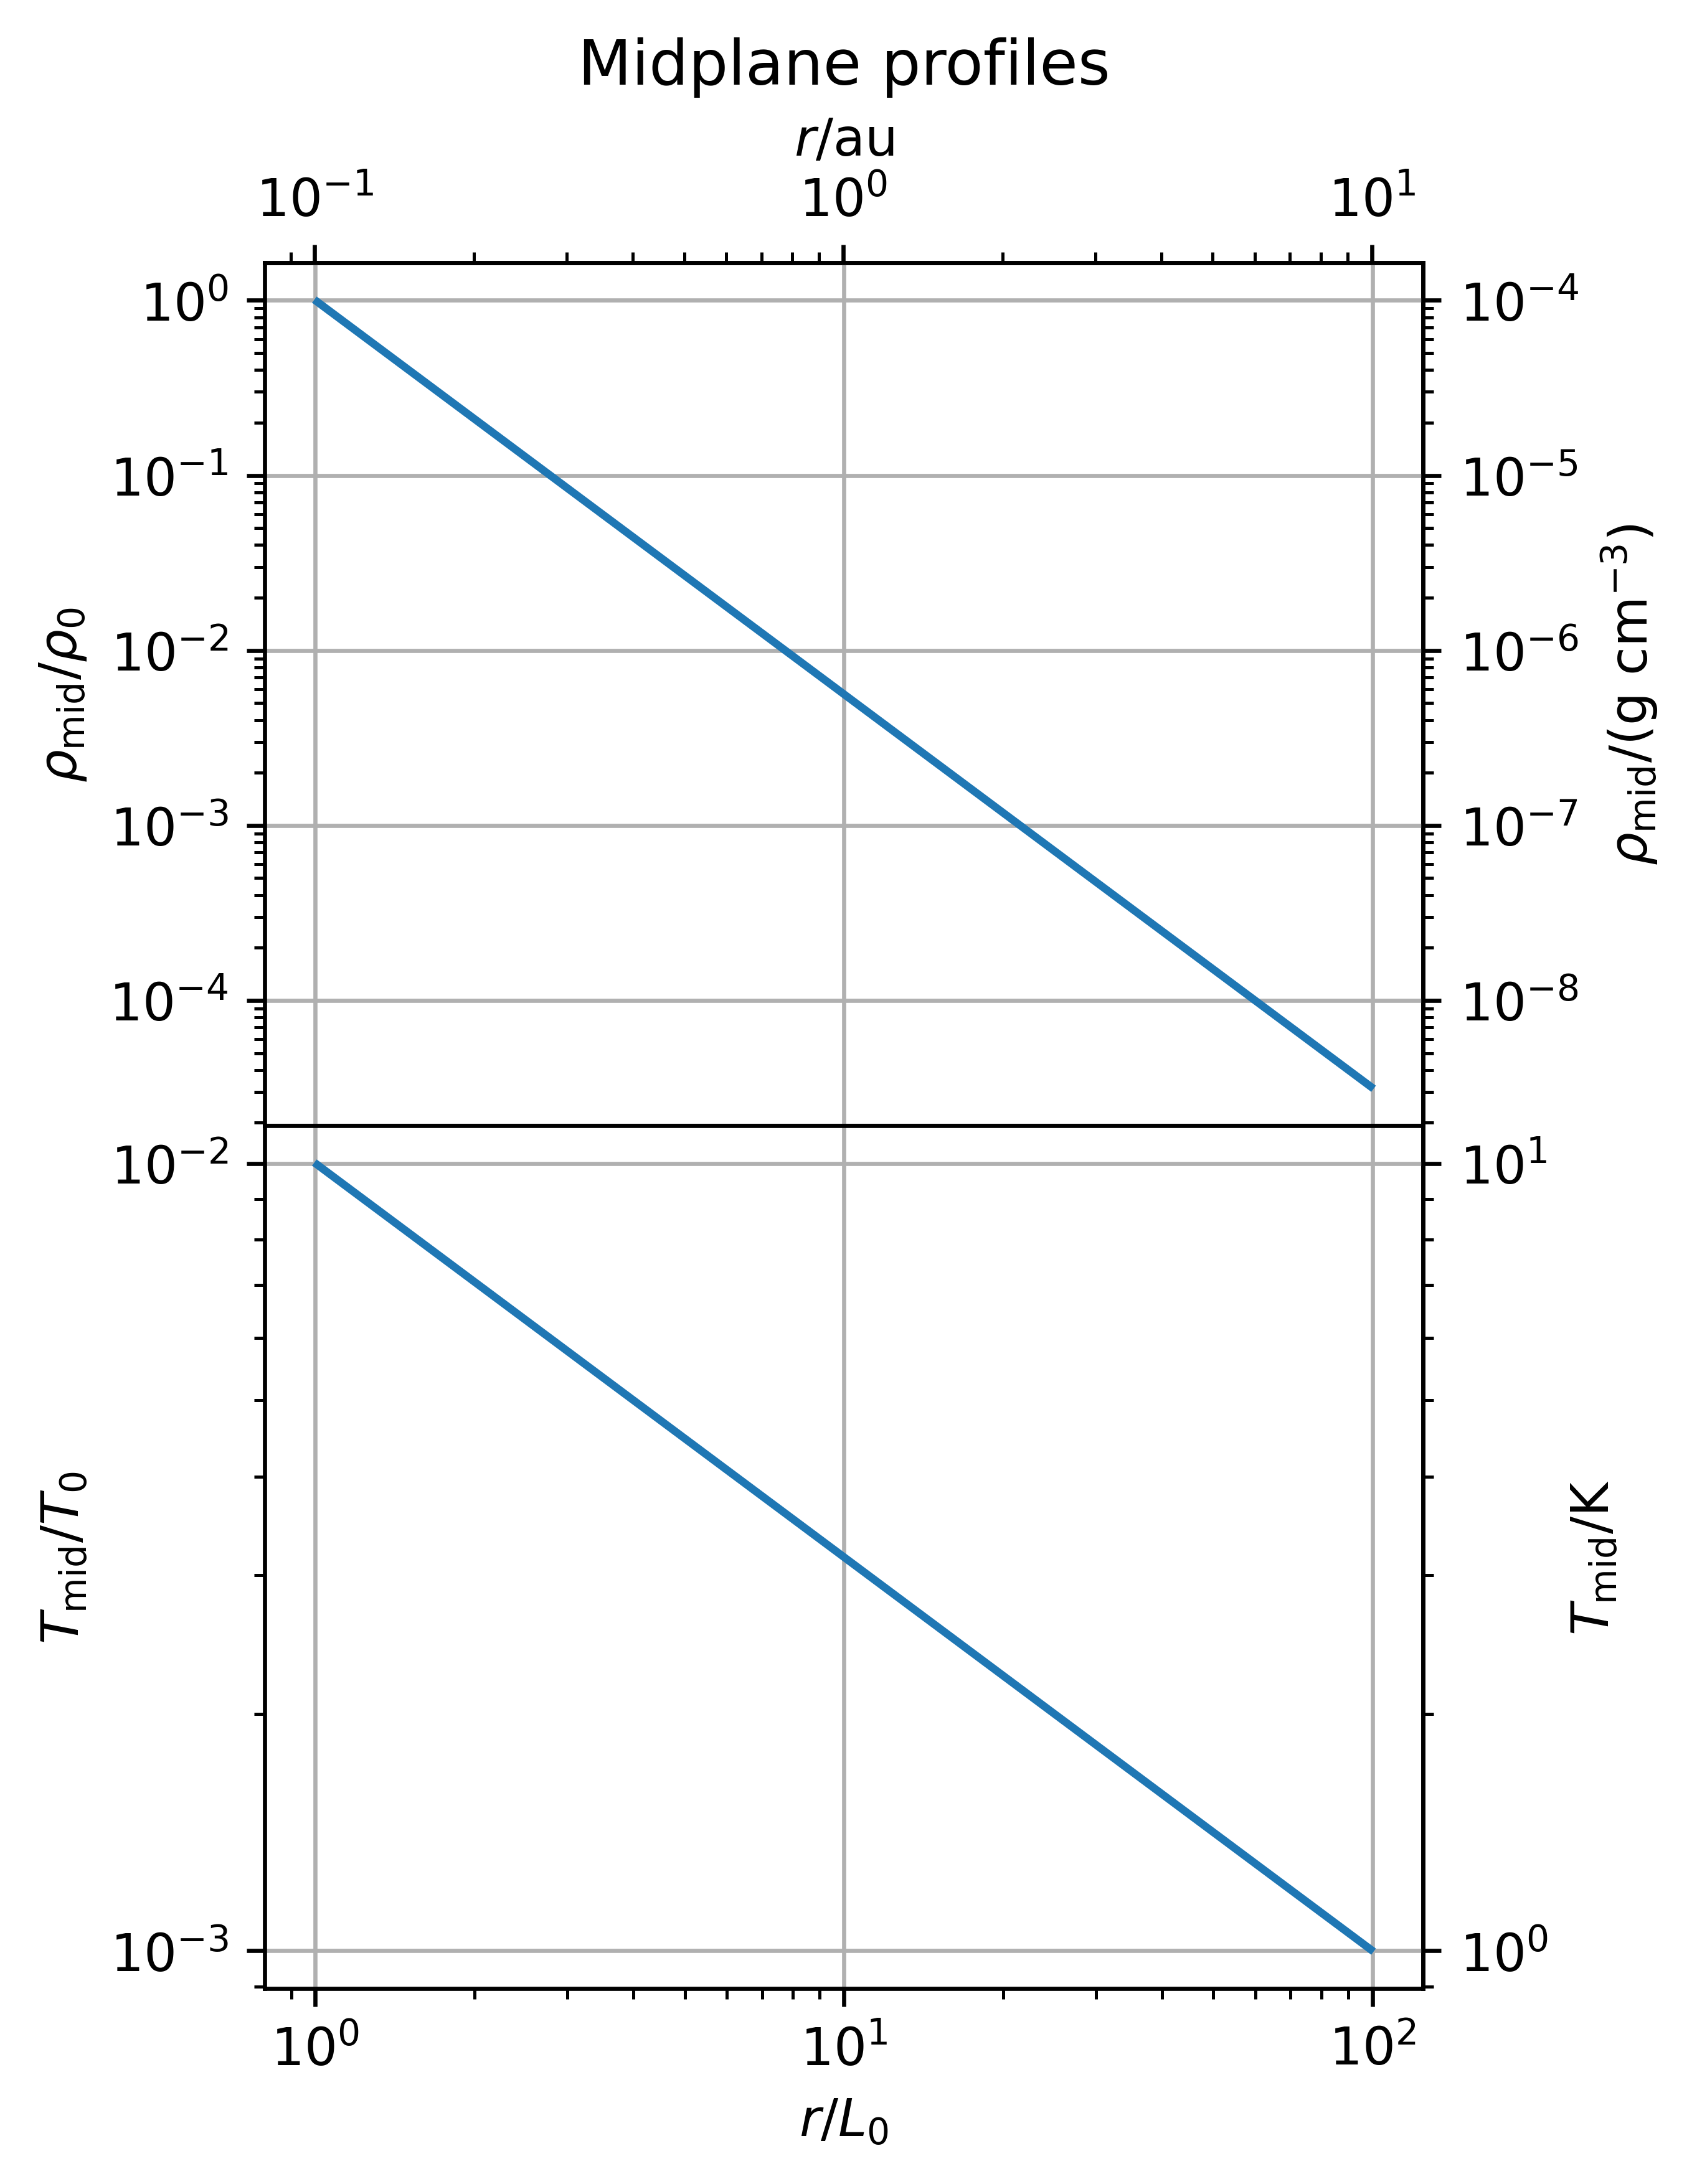

In [1]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# BEGIN disk.cpp
# namespace {
# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = np.abs(x1*np.sin(x2))
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(rad, phi, z):
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power(rad/r0, dslope)
  dentem = denmid*np.exp(GM/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# END disk.cpp

# begin athinput.disk_sph
# <mesh>
nx1              = 256                 # Number of zones in X1-direction
x1min            = 1.0                 # minimum value of X1
x1max            = 100.0               # maximum value of X1

nx2              = 512                 # Number of zones in X2-direction
x2min            = 0                   # minimum value of X2
x2max            = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor           = 1e-24               # minimum density

# <radiation>
unit             = 1                   # compute prat & crat from user-provided units
T_unit           = 1.00e3              # T_0 (T_eff) [K]
density_unit     = 1.00e-4             # \rho_0 (at r0) [g/cm^3]
length_unit      = 1.50e12             # L_0 (0.1 au) [cm]

# <problem>
GM               = 1.0                 # central mass [GM_0]
r0               = 1.0                 # disk radial normalization [L_0]
rho0             = 1.0                 # disk density normalization [\rho_0]
p0_over_r0       = 0.01                # (H/r0)^2
pslope           = -0.5                # pressure power-law index
dslope           = -2.25               # density power-law index
# end athinput.disk

# Solar constants, astrophysical units and conversions
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]
rad2deg          = 180/np.pi           # [deg]

# Generate fields
x1f = np.logspace(np.log10(x1min), np.log10(x1max), nx1+1)
x2f = np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rads, phis, zs = GetCylCoord(x1mesh, x2mesh, 0)
rho_field_theo = DenProfileCyl(rads, phis, zs)
rho_field_theo[rho_field_theo < dfloor] = dfloor
T_field_theo = PoverR(rads, phis, zs)
dtheta_theo = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta_theo)

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=600)
axs[0].plot(x1v, rho_field_theo[j_mid, :])
axs[1].plot(x1v, T_field_theo[j_mid, :])

# Format secondary axes in cgs
def r2au(r):
  return r*L_au
def rho2cgs(rho):
  return rho*density_unit
def T2cgs(T):
  return T*T_unit
ax_r = axs[0].secondary_xaxis('top', functions=(r2au, r2au))
ax_rho = axs[0].secondary_yaxis('right', functions=(rho2cgs, rho2cgs))
ax_T = axs[1].secondary_yaxis('right', functions=(T2cgs, T2cgs))
ax_r.set(xlabel=r'$r$/au')
ax_r.minorticks_on()
ax_rho.set(ylabel=r'$\rho_\mathrm{mid}$/(g cm$^{-3}$)')
ax_rho.minorticks_on()
ax_T.set(ylabel=r'$T_\mathrm{mid}$/K')
ax_T.minorticks_on()

# Format subplots
for ax in axs:
  ax.set(xscale='log', yscale='log')
  ax.grid()
  ax.minorticks_on()
axs[0].set(title='Midplane profiles', ylabel=r'$\rho_\mathrm{mid}/\rho_0$')
axs[1].set(xlabel=r'$r/L_0$', ylabel=r'$T_\mathrm{mid}/T_0$')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

[Text(0.5, 0, '$r/L_0$')]

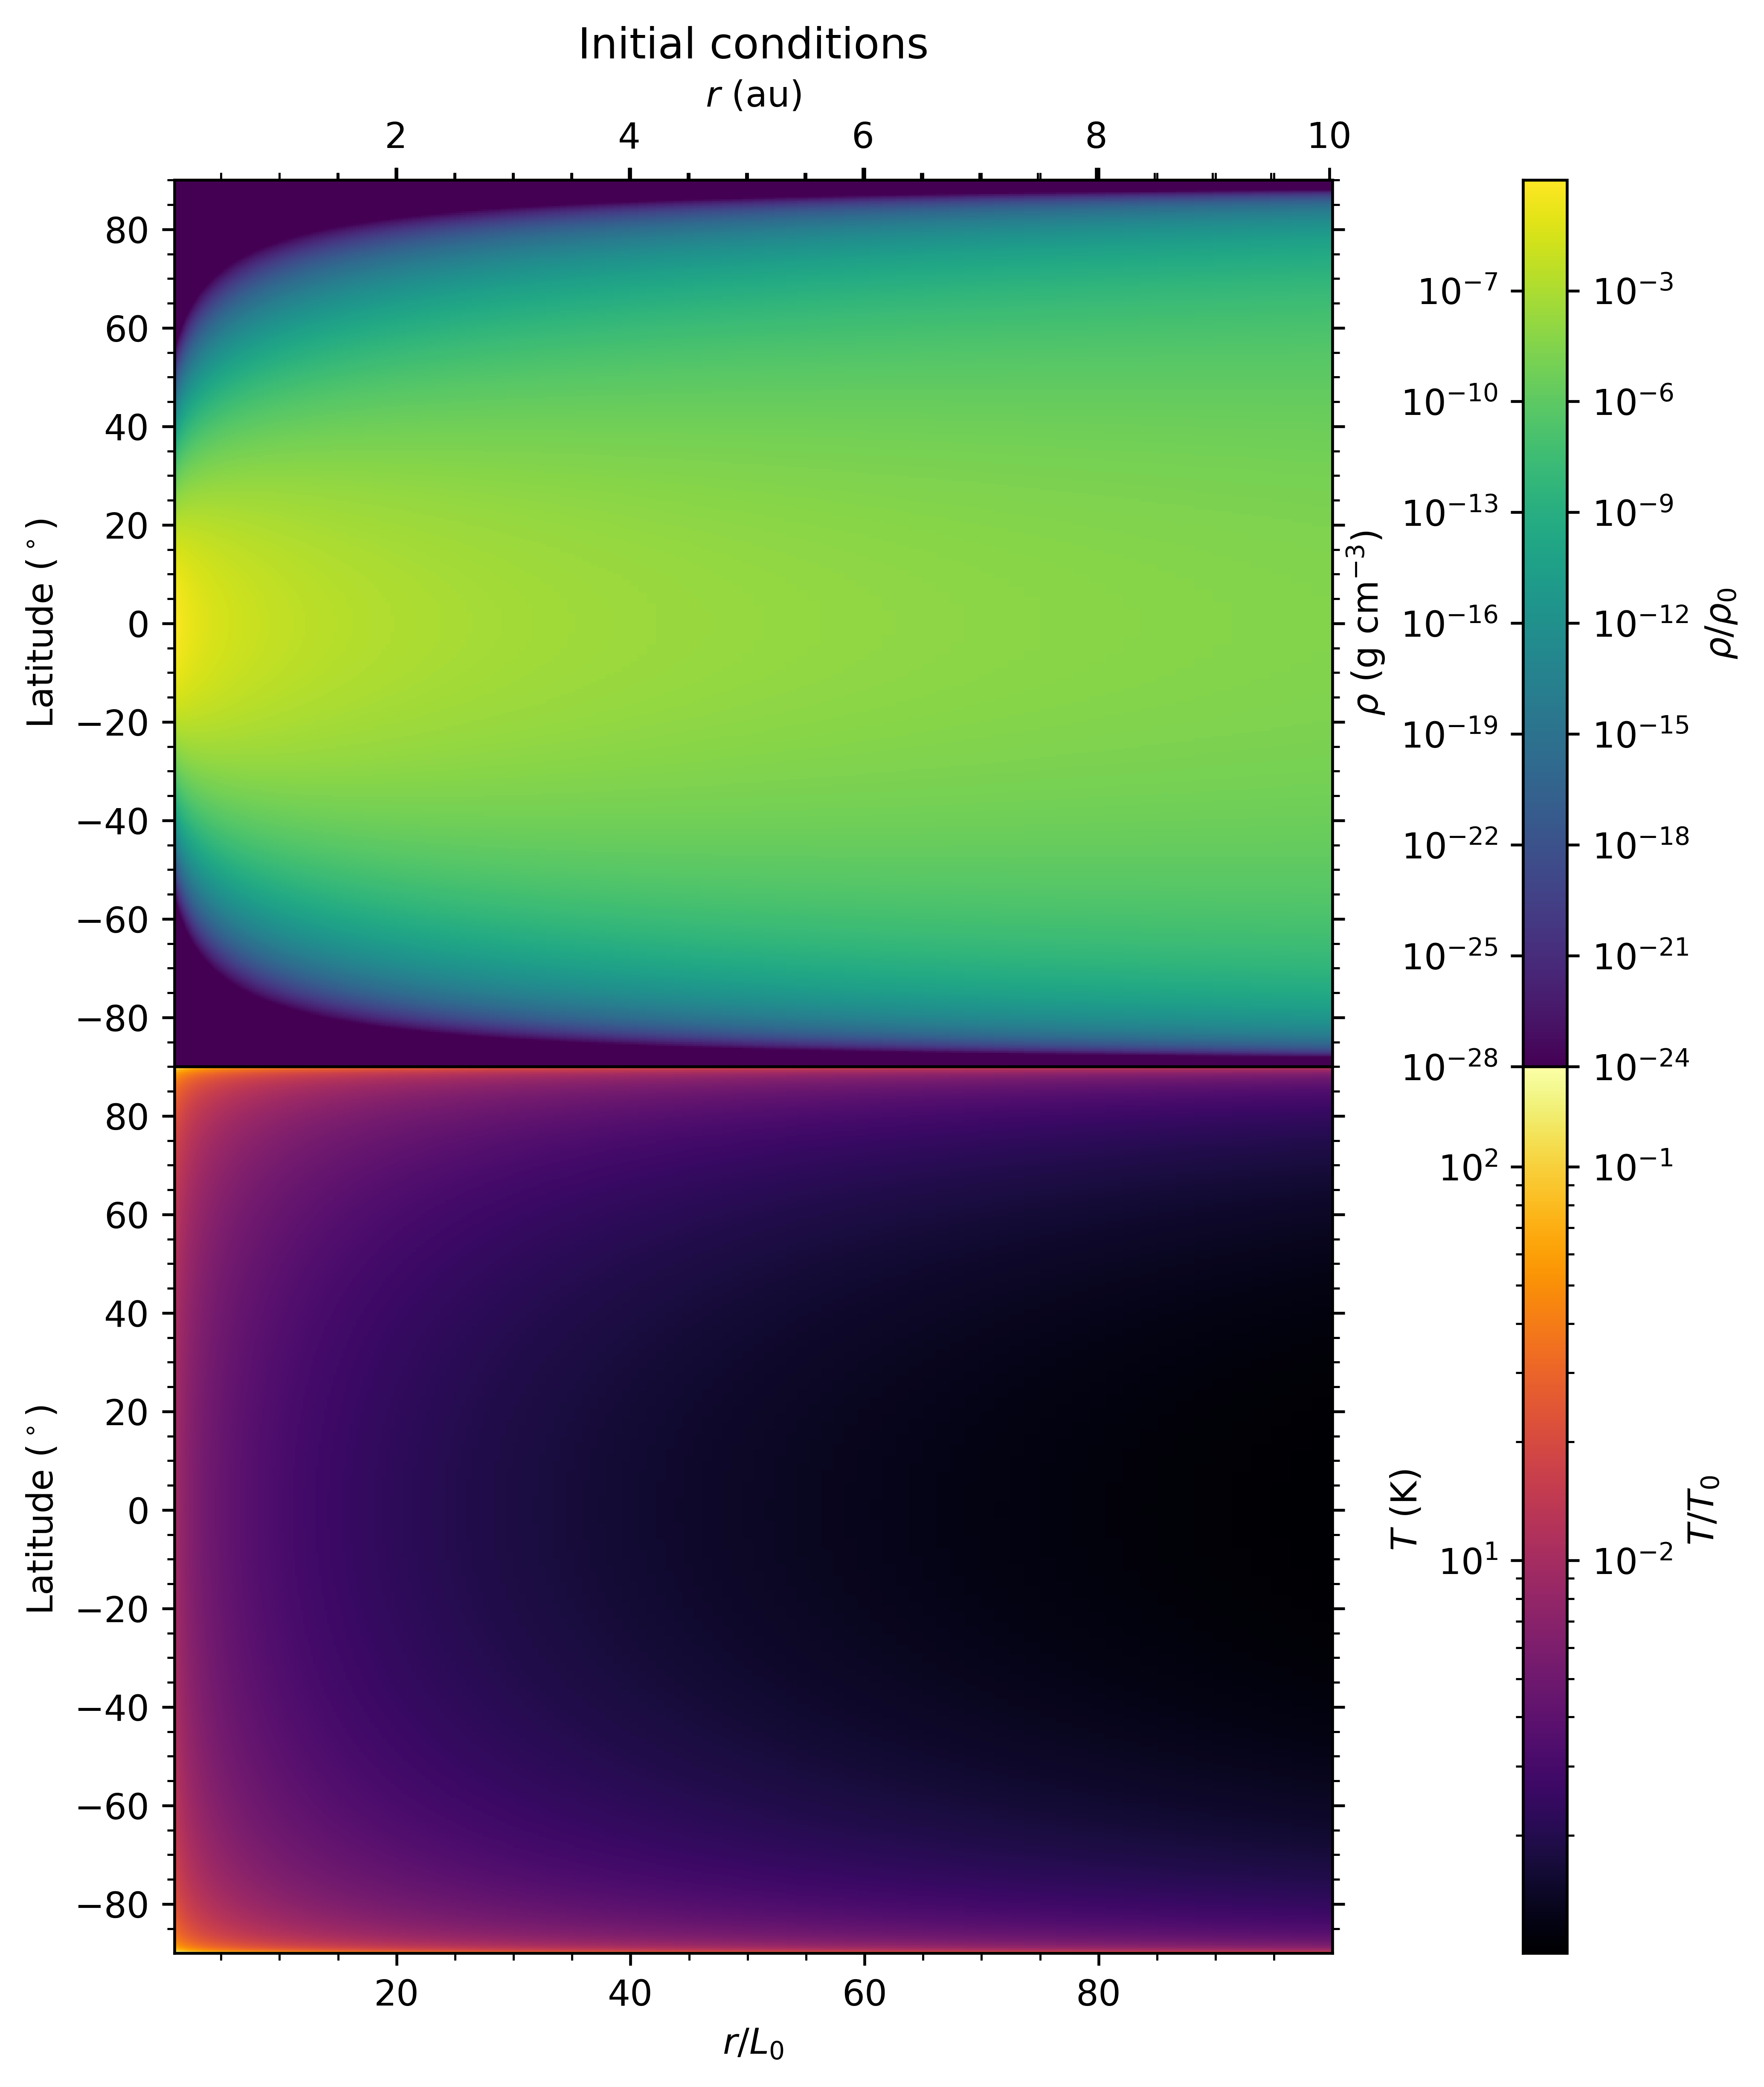

In [2]:
#===============================================================================
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 9), dpi=600)

# Read and plot
# Density field
im0 = axs[0].pcolormesh(x1v, 90-x2v*rad2deg, rho_field_theo, cmap='viridis',
                        norm=colors.LogNorm())
# Temperature field
im1 = axs[1].pcolormesh(x1v, 90-x2v*rad2deg, T_field_theo, cmap='inferno',
                        norm=colors.LogNorm())

# Constants
arad = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
au      = 1.495978707e13 # astronomical unit [cm]
L_au    = length_unit/au # [au]

# Format secondary (colorbar) scales in cgs
def r2au(r):
  return r*L_au
def rho2cgs(rho):
  return rho*density_unit
def T2cgs(T):
  return T*T_unit
ax_r = axs[0].secondary_xaxis('top', functions=(r2au, r2au))
ax_r.set(xlabel=r'$r$ (au)')
ax_r.minorticks_on()
cbar_rho = plt.colorbar(im0, label=r'$\rho/\rho_0$', pad=0.12)
cbar_rho_cgs = cbar_rho.ax.secondary_yaxis('left', functions=(rho2cgs, rho2cgs))
cbar_rho_cgs.set(ylabel=r'$\rho$ (g cm$^{-3}$)')
cbar_T = plt.colorbar(im1, label=r'$T/T_0$', pad=0.12)
cbar_T_K = cbar_T.ax.secondary_yaxis('left', functions=(T2cgs, T2cgs))
cbar_T_K.set(ylabel=r'$T$ (K)')

# Format (sub)plots
for i, ax in enumerate(axs):
  ax.minorticks_on()
  ax.set(ylabel=r'Latitude ($^\circ$)')
  ax.tick_params(axis='both', which='both', right=True)
plt.subplots_adjust(hspace=0)
axs[0].set(title='Initial conditions')
axs[0].tick_params(axis='both', which='both', top=True)
axs[1].set(xlabel=r'$r/L_0$')
# plt.savefig('initial.png', bbox_inches='tight', pad_inches=0.01)